# Todo junto

Ahora vamos a entrenar un modelo, poniendo en práctica todo lo visto hasta ahora. Lo vamos a hacer con el conjunto de datos cancer

In [1]:
from sklearn import datasets
import pandas as pd

cancer = datasets.load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Creamos el dataset y lo dividimos en `train` y `val`

In [2]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)

train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))
len(train_ds), len(valid_ds)

(455, 114)

## Batch size finder

Creamos el dataloader. Como hemos visto cuantos más datos se pongan en cada batch el entrenamiento es mejor, es decir, cuanto más grande sea el `batch size`

Vamos a usar el algoritmo del `batch size finder` para intentar usar el mayor número de datos a la vez

Primero tenemos que crear nuestra red neuronal, vamos a hacer una más grande que la que hemos hecho hasta ahora para asergurarnos que pueda aprender bien

Como funciones de activación usamos `ReLU`s. Como es un problema de clasificación binaria no obtenemos las probabilidades de cada salida porque luego usaremos `BCEWithLogitsLoss` como función de pérdida

Metemos una capa de `dropout` como regularización

Metemos también una capa de normalización de las capas

Usamos el método `Xavier` como inicialización de los parámetros

In [3]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[200, 150, 100, 75, 50, 25, 20], dropout=0.5):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], hidden_layers[3]),
            torch.nn.BatchNorm1d(hidden_layers[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_layers[3], hidden_layers[4]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[4], hidden_layers[5]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[5], hidden_layers[6]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[6], num_outputs),
        )
        self.apply(self._init_weights)
        self.activation = torch.nn.Sigmoid()
    
    # Weights initialization using Xavier's method
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

num_inputs = 31
num_outputs = 1
model = CancerNeuralNetwork(num_inputs, num_outputs)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model.to(device)

Using cuda device


CancerNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=75, bias=True)
    (7): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=75, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=25, bias=True)
    (13): ReLU()
    (14): Linear(in_features=25, out_features=20, bias=True)
    (15): ReLU()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

Definimos una función para poder ver la memoria libre, la ocupada y la total de la GPU

In [4]:
import subprocess as sp

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.total --format=csv"
    memory_total_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_total_values = [int(x.split()[0]) for i, x in enumerate(memory_total_info)]

    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]

    command = "nvidia-smi --query-gpu=memory.used --format=csv"
    memory_used_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_used_values = [int(x.split()[0]) for i, x in enumerate(memory_used_info)]
    return memory_total_values, memory_free_values, memory_used_values

total, free, used = get_gpu_memory()
print(f"GPU memory: total: {total} MiB, free: {free} MiB, used: {used} MiB")

GPU memory: total: [4096] MiB, free: [3484] MiB, used: [429] MiB


Definimos la función de pérdida y el optimizador.

Como este es un problema de clasificación binaria usamos la función de pérdida `BCEWithLogitsLoss` que como hemos visto es la mejor.

Como optimizador usarmos `Adam` que también hemos visto que es el mejor

In [5]:
LR = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

Definimos la función de entrenamiento

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for (X, y) in dataloader:
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits, _ = model(X)
        loss = loss_fn(logits, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Creamos una lista con los posibles valores de `batch size` que vamos a evaluar

In [7]:
def list_of_posible_batch_sizes(dataset):
    batch_sizes = []
    batch_size = 1
    while batch_size < 2*len(dataset):
        batch_sizes.append(batch_size)
        batch_size *= 2
    batch_sizes.sort(reverse=True)
    return batch_sizes

BSs = list_of_posible_batch_sizes(train_ds)
BSs

[512, 256, 128, 64, 32, 16, 8, 4, 2, 1]

In [8]:
from torch.utils.data import DataLoader

for BS_train in BSs:
    print(f"batch size: {BS_train}")
    train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)
    epochs = 3
    out_of_memory = False
    for t in range(epochs):
        try:
            train_loop(train_dl, model, loss_fn, optimizer)
        except Exception as e:
            print(f'Error: {e}')
            out_of_memory = True
            break
    if out_of_memory == False:
        break
    print()
print(f"Done!, bacth size is {BS_train}")

batch size: 512
Done!, bacth size is 512


Vemos que con un `batch size` de 512 no nos quedamos sin memoria

## Learning rate finder

In [9]:
from torch.utils.data import DataLoader

BS_train = 4 # Elegimos un batch size de 4 para tener varios valores de lr para probar
BS_val = 128

train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BS_val, shuffle=False)

Creamos la función de learning rate finder

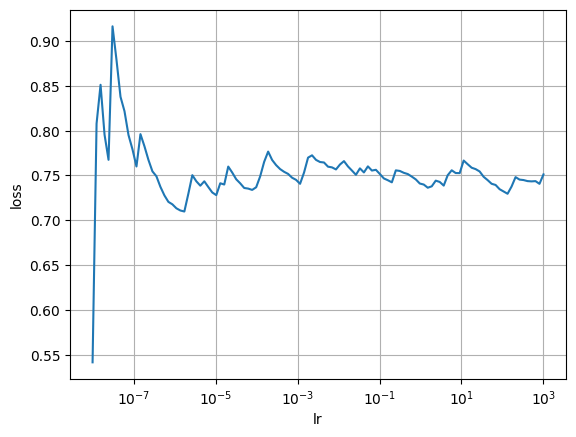

In [10]:
import matplotlib.pyplot as plt

def lr_finder(model, train_dl, loss_fn, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
    num = len(train_dl)-1 # Numero de lrs que vamos a probar
    q = (lr_end/lr_init)**(1/num) # Incremento de lr
    lr = lr_init
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss = 0
    best_loss = 0.
    avg_loss = 0.
    smoothed_avg_losses = []
    lrs = []
    for batch, (X, y) in enumerate(train_dl):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits, _ = model(X)
        loss = loss_fn(logits, y)
        avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
        smoothed_loss = avg_loss / (1 - beta**(batch+1))
        if increment is not None:
            # Se para si el loss se dispara
            window = 10
            if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                return lrs, smoothed_avg_losses
        
        # Se guarda la menor pérdida
        if avg_loss < best_loss or batch==0:
            best_loss = smoothed_loss
        
        # Se guardan los datos
        smoothed_avg_losses.append(smoothed_loss)
        lrs.append(lr)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lr
        lr *= q

    return lrs, smoothed_avg_losses

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
seed = 27
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs, num_outputs)
model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
[lrss, smoothed_avg_losses] = lr_finder(model, train_dl, loss_fn, lr_end=1000)

plt.plot(lrss, smoothed_avg_losses)
plt.xlabel("lr")
plt.ylabel("loss")
plt.xscale("log")
plt.grid()
plt.show()

Como no hay un valor muy claro nos quedamos con $10^{-3}$

## Entrenamiento

Volvemos a crear el dataset con el tamaño de `batch size` calculado anteriormente

In [11]:
BS_train = 512
BS_val = 128

train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BS_val, shuffle=False)

Volvemos a instanciar la red neuronal para que se inicialicen los pesos otra vez

In [12]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs, num_outputs)
model.to(device)

CancerNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=75, bias=True)
    (7): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=75, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=25, bias=True)
    (13): ReLU()
    (14): Linear(in_features=25, out_features=20, bias=True)
    (15): ReLU()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

Definimos las funciones de error y el optimizador. Elegimos el `learning rate` calculado anteriormente. Tambien añadimos el parámetro `weight_decay` en el optimizador para regularización

In [13]:
LR = 1e-3
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

Entrenamos como hemos visto hasta ahora. Además añadimos un `learning rate scheduller` de manera que si en 10 épocas el error de validación no mejora se reduzca el valor del lerning rate

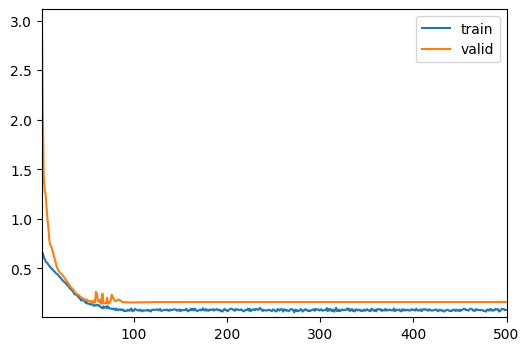

Epoch 00076: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00087: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00098: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00109: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00120: reducing learning rate of group 0 to 1.0000e-08.


In [14]:
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
import os

def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

path_folder = "data/"
# Si el directorio donde se va a guardar el modelo no existe, se crea
if not os.path.isdir(path_folder):
    os.mkdir(path_folder)

epochs = 500
mb = master_bar(range(1, epochs+1))
train_loss, valid_loss = [], []
correct_metric = 0
schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
for epoch in mb:
    # train loop
    model.train()
    for (X, y) in progress_bar(train_dl, parent=mb):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits, _ = model(X)
        loss = loss_fn(logits, y)
        mb.child.comment = f'train loss: {loss.item():>7f}'

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # validation loop
    num_batches = len(val_dl)
    val_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in progress_bar(val_dl, parent=mb):
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            logits, probs = model(X)
            val_loss += loss_fn(logits, y).item()
            correct += (probs.round() == y).type(torch.float).sum().item()
            mb.child.comment = f'epoch: {epoch}/{epochs}, val loss: {val_loss:>7f}, correct: {int(correct):03d}'

    train_loss.append(loss.item())
    valid_loss.append(val_loss)
    mb.main_bar.comment = f'epoch: {epoch}/{epochs}, train loss: {train_loss[-1]:>7f}, valid loss: {valid_loss[-1]:>7f}'
    if int(correct) > correct_metric:
        best_model_name = f'best_model_epoch_{epoch}.zip'
        model_path = path_folder + best_model_name
        correct_metric = int(correct)
        # Remove the previous best model
        for f in os.listdir(path_folder):
            os.remove(os.path.join(path_folder, f))
        # Save model
        torch.jit.save(torch.jit.script(model), model_path)
        mb.write(f'epoch: {epoch}, train loss: {train_loss[-1]:>7f}, valid loss: {valid_loss[-1]:>7f}, correct: {int(correct):>3d}, best model')
    
    # Update learning rate
    schedulerOnPlateau.step(val_loss)

    plot_loss_update(epoch, epochs, mb, train_loss, valid_loss)